<a href="https://colab.research.google.com/github/JHyunjun/SNU/blob/main/Continuous%20Learning2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import tqdm
import pandas

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset

import torchvision.transforms as transforms
from torchvision import models

from PIL import Image
import matplotlib.pyplot as plt

# Data download

https://www.kaggle.com/moltean/fruits

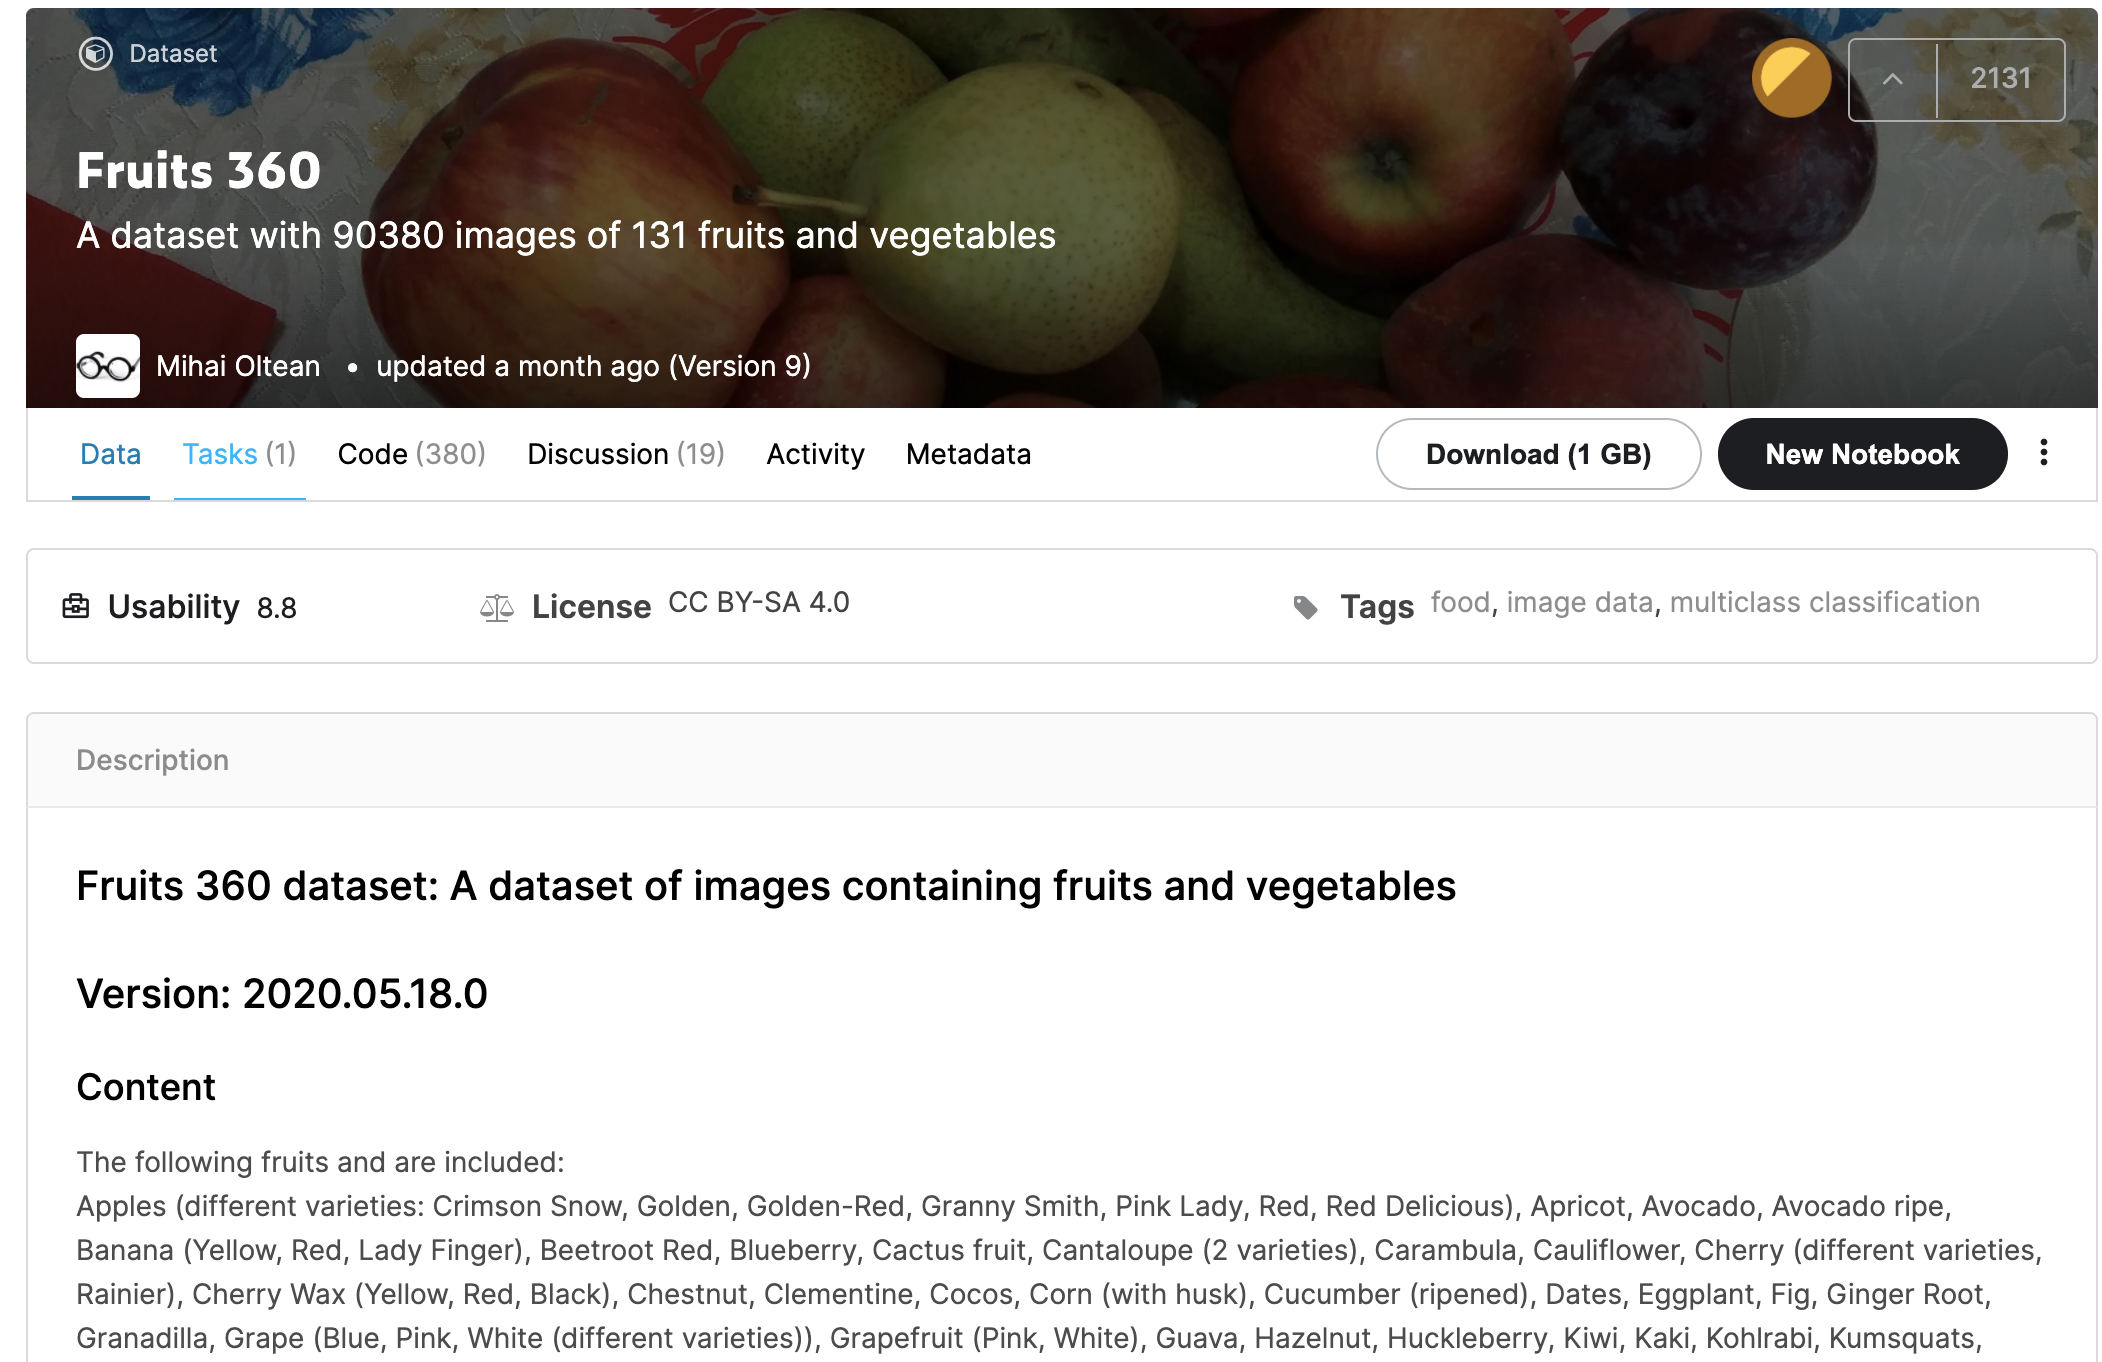

In [2]:
# download datasets
!gdown https://drive.google.com/uc?id=1OhzyMI33ckEvuF9cceInop8nKaWh2Hqc
# unzip it
!unzip archive.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/111_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/124

We will use data in **fruits-360_dataset!**

Let's take a look at the actual images!

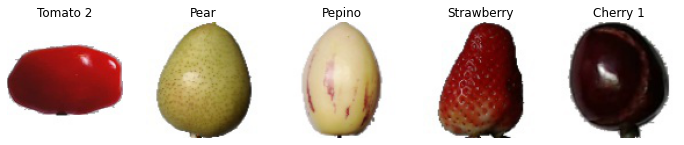

In [3]:
# TODO 1. plot 5 train examples
plt.figure(figsize=(12,8))

train_path = os.path.join('fruits-360_dataset', 'fruits-360', 'Training')

i = 1
classes = os.listdir(train_path)
for cls in classes[:5]:
  cls_path = os.path.join(train_path, cls)

  img_fnames = os.listdir(cls_path)
  for img_fname in img_fnames[:1]:
    img_path = os.path.join(cls_path, img_fname)

    img = Image.open(img_path)
    plt.subplot(1, 5, i)
    plt.axis('off')
    plt.imshow(img)
    plt.title(cls)

    i += 1
  
plt.show()

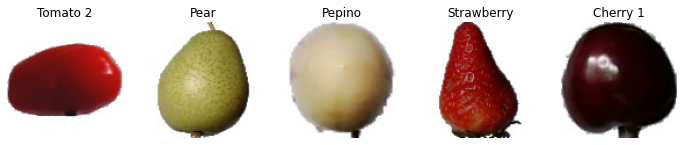

In [4]:
# TODO 1. plot 5 test examples
plt.figure(figsize=(12,8))

test_path = os.path.join('fruits-360_dataset', 'fruits-360', 'Test')

i = 1
classes = os.listdir(test_path)
for cls in classes[:5]:
  cls_path = os.path.join(test_path, cls)

  img_fnames = os.listdir(cls_path)
  for img_fname in img_fnames[:1]:
    img_path = os.path.join(cls_path, img_fname)

    img = Image.open(img_path)
    plt.subplot(1, 5, i)
    plt.axis('off')
    plt.imshow(img)
    plt.title(cls)

    i += 1
  
plt.show()

# Build dataset

In [5]:
NAME_TO_LABEL = {name:label for label, name in 
                 enumerate(os.listdir(os.path.join('fruits-360_dataset', 'fruits-360', 'Training')))}
LABEL_TO_NAME = {label:name for name, label in NAME_TO_LABEL.items()}

# TODO 1. build train dataset
class TrainDataset(Dataset):
  def __init__(self, train_path, transform=transforms.ToTensor()):
    super().__init__()
    self.train_path = train_path
    self.transform = transform

    self.img_path = list()
    self.labels = list()
    for cls in os.listdir(train_path):
      cls_path = os.path.join(train_path, cls)
      for img_fname in os.listdir(cls_path):
        self.img_path.append(os.path.join(cls_path, img_fname))
        self.labels.append(NAME_TO_LABEL[cls])

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.transform(Image.open(self.img_path[idx])), self.labels[idx]

# TODO 2. build test dataset
class TestDataset(Dataset):
  def __init__(self, test_path, transform=transforms.ToTensor()):
    super().__init__()
    self.test_path = test_path
    self.transform = transform
    
    self.img_path = list()
    self.labels = list()
    for cls in os.listdir(test_path):
      cls_path = os.path.join(test_path, cls)
      for img_fname in os.listdir(cls_path):
        self.img_path.append(os.path.join(cls_path, img_fname))
        self.labels.append(NAME_TO_LABEL[cls])

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.transform(Image.open(self.img_path[idx])), self.labels[idx]

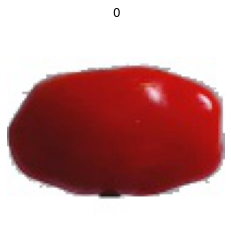

In [6]:
pil_converter = transforms.ToPILImage()
# Test your train dataset
train_dataset = TrainDataset(train_path=os.path.join('fruits-360_dataset', 'fruits-360', 'Training'))
img1, label1 = train_dataset[0]
plt.imshow(pil_converter(img1))
plt.title(label1)
plt.axis('off')
plt.show()

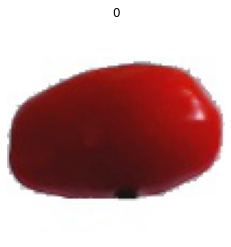

In [7]:
# Test your test dataset
test_dataset = TestDataset(test_path=os.path.join('fruits-360_dataset', 'fruits-360', 'Test'))
img1, label1 = test_dataset[0]
plt.imshow(pil_converter(img1))
plt.title(label1)
plt.axis('off')
plt.show()

In [8]:
# TODO 1. build split train dataset
class SplitTrainDataset(Dataset):
  def __init__(self, train_path, transform=transforms.ToTensor(), classes=[]):
    super().__init__()
    self.train_path = train_path
    self.transform = transform

    self.img_path = list()
    self.labels = list()
    for cls in os.listdir(train_path):
      if cls not in classes:
        continue
      cls_path = os.path.join(train_path, cls)
      for img_fname in os.listdir(cls_path):
        self.img_path.append(os.path.join(cls_path, img_fname))
        self.labels.append(NAME_TO_LABEL[cls])

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.transform(Image.open(self.img_path[idx])), self.labels[idx]

# TODO 2. build split test dataset
class SplitTestDataset(Dataset):
  def __init__(self, test_path, transform=transforms.ToTensor(), classes=[]):
    super().__init__()
    self.test_path = test_path
    self.transform = transform
    
    self.img_path = list()
    self.labels = list()
    for cls in os.listdir(test_path):
      if cls not in classes:
        continue
      cls_path = os.path.join(test_path, cls)
      for img_fname in os.listdir(cls_path):
        self.img_path.append(os.path.join(cls_path, img_fname))
        self.labels.append(NAME_TO_LABEL[cls])

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.transform(Image.open(self.img_path[idx])), self.labels[idx]

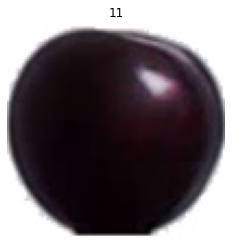

In [9]:
classes = ['Tomato 4', 'Cherry Wax Black']
# Test your train dataset
train_dataset = SplitTrainDataset(train_path=os.path.join('fruits-360_dataset', 'fruits-360', 'Training'), 
                                  classes=classes)
img1, label1 = train_dataset[0]
plt.imshow(pil_converter(img1))
plt.title(label1)
plt.axis('off')
plt.show()

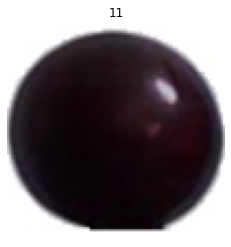

In [10]:
# Test your test dataset
test_dataset = SplitTestDataset(test_path=os.path.join('fruits-360_dataset', 'fruits-360', 'Test'),
                                classes=classes)
img1, label1 = test_dataset[0]
plt.imshow(pil_converter(img1))
plt.title(label1)
plt.axis('off')
plt.show()

In [11]:
tasks = []
for i in range(len(LABEL_TO_NAME) // 30):
  task = [LABEL_TO_NAME[i*30 + j] for j in range(30)]
  tasks.append(task)

left = len(LABEL_TO_NAME) % 30
if left > 0:
  last = (len(LABEL_TO_NAME) // 30 ) * 30
  tasks.append([LABEL_TO_NAME[last + i] for i in range(left)])

In [12]:
transform = transforms.Compose([transforms.ToTensor(),
                                lambda x: x.repeat(3, 1, 1) if x.size(0) != 3 else x])

train_datasets = []
test_datasets = []
for task in tasks:
  train_datasets.append(SplitTrainDataset(train_path, transform, task))
  test_datasets.append(SplitTestDataset(test_path, transform, task))

# Hyper parameter setting

In [13]:
# use gpu if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");

batch_size = 64
lr = 0.0001

# Model Preparation

In [14]:
# TODO 1: get a model from torchvisoin.models
#model = models.resnet34(pretrained=True)
#model.fc = nn.Linear(model.fc.in_features, len(NAME_TO_LABEL))
model = models.densenet121(pretrained=True)
model.clasifier = nn.Linear(model.classifier.in_features, len(NAME_TO_LABEL))
model.to(device)

# TODO 2: get a optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

# Training and evaluation

In [15]:
def train(model, dataloader, optimizer):
    # TODO 1: complete training code
    # 1) iterate dataloader
    # 2) calculate loss
    # 3) use the optimizer to train the model
    model.train()
    
    for x, y in tqdm.notebook.tqdm(dataloader, desc='train', leave=False):
      x, y = x.to(device), y.to(device)

      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()


def test(model, dataloader):
    # TODO 2: complete testing code
    # TODO 3: print total loss and accuracy of the model
    # 1) iterate dataloader
    # 2) calculate loss
    # 3) calculate accuracy
    # 4) print results
    model.eval()
    test_loss = 0
    correct = 0
    ns = 0
    for x, y in tqdm.notebook.tqdm(dataloader, desc='test', leave=False):
      with torch.no_grad():
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y)
        pred = torch.argmax(output, dim=1)
        correct += torch.sum(pred == y)
        ns += len(y)

    test_loss /= ns
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, ns,
        100. * correct / ns))
    return 100. * correct / ns

In [16]:
for ti in range(len(tasks)):
  print("Train: task {}".format(ti))
  train_dataloader = DataLoader(train_datasets[ti], batch_size=batch_size, shuffle=True)
  train(model, train_dataloader, optimizer)
  print('\n')
  
  for tj in range(ti + 1):
    print("Test: task {}".format(tj))
    test_dataloader = DataLoader(test_datasets[tj], batch_size=batch_size)
    test(model, test_dataloader)
  print("\n")

Train: task 0


train:   0%|          | 0/240 [00:00<?, ?it/s]



Test: task 0


test:   0%|          | 0/81 [00:00<?, ?it/s]

Test set: Average loss: 0.0013, Accuracy: 5069/5139 (99%)


Train: task 1


train:   0%|          | 0/248 [00:00<?, ?it/s]



Test: task 0


test:   0%|          | 0/81 [00:00<?, ?it/s]

Test set: Average loss: 0.0627, Accuracy: 1631/5139 (32%)
Test: task 1


test:   0%|          | 0/83 [00:00<?, ?it/s]

Test set: Average loss: 0.0011, Accuracy: 5261/5306 (99%)


Train: task 2


train:   0%|          | 0/238 [00:00<?, ?it/s]



Test: task 0


test:   0%|          | 0/81 [00:00<?, ?it/s]

Test set: Average loss: 0.1009, Accuracy: 121/5139 (2%)
Test: task 1


test:   0%|          | 0/83 [00:00<?, ?it/s]

Test set: Average loss: 0.0792, Accuracy: 962/5306 (18%)
Test: task 2


test:   0%|          | 0/80 [00:00<?, ?it/s]

Test set: Average loss: 0.0002, Accuracy: 5084/5102 (100%)


Train: task 3


train:   0%|          | 0/248 [00:00<?, ?it/s]



Test: task 0


test:   0%|          | 0/81 [00:00<?, ?it/s]

Test set: Average loss: 0.1488, Accuracy: 4/5139 (0%)
Test: task 1


test:   0%|          | 0/83 [00:00<?, ?it/s]

Test set: Average loss: 0.1259, Accuracy: 36/5306 (1%)
Test: task 2


test:   0%|          | 0/80 [00:00<?, ?it/s]

Test set: Average loss: 0.0870, Accuracy: 910/5102 (18%)
Test: task 3


test:   0%|          | 0/83 [00:00<?, ?it/s]

Test set: Average loss: 0.0002, Accuracy: 5291/5305 (100%)


Train: task 4


train:   0%|          | 0/86 [00:00<?, ?it/s]



Test: task 0


test:   0%|          | 0/81 [00:00<?, ?it/s]

Test set: Average loss: 0.1195, Accuracy: 29/5139 (1%)
Test: task 1


test:   0%|          | 0/83 [00:00<?, ?it/s]

Test set: Average loss: 0.1402, Accuracy: 15/5306 (0%)
Test: task 2


test:   0%|          | 0/80 [00:00<?, ?it/s]

Test set: Average loss: 0.1225, Accuracy: 367/5102 (7%)
Test: task 3


test:   0%|          | 0/83 [00:00<?, ?it/s]

Test set: Average loss: 0.1050, Accuracy: 502/5305 (9%)
Test: task 4


test:   0%|          | 0/29 [00:00<?, ?it/s]

Test set: Average loss: 0.0031, Accuracy: 1775/1836 (97%)




# Build replay buffer

Now, let's use a buffer to contain data of previous tasks and use these preserved data along with newly observed ones for model training.

To do so, we need to build our own buffer object which saves observed data in a limited memory.

In [17]:
class Buffer():
  def __init__(self, buffer_size):
    self.buffer_size = buffer_size
    self.images = []
    self.labels = []
    self.n = 0

  def __len__(self):
    return len(self.labels)

  def update(self, image, label):
    if self.buffer_size == 0:
      return

    # TODO 1. complete the update function
    # input: a image and label pairs
    # if buffer is not full -> save the input image and label to buffer
    # else -> save the input image and label to buffer with the probability of M/N
    #         M: buffer size, N: the number of examples seen so far.
    #         thanks to the probability, we can approximate iid assumption.
    if self.n < self.buffer_size:
      self.images.append(image)
      self.labels.append(label)
    else:
      pos = random.randrange(0, self.n)
      if pos < self.buffer_size:
        self.images[pos] = image
        self.labels[pos] = label
    self.n += 1
  
  def sample(self, sample_num):
    # TODO 2. complete the sample function
    # input: sample num (if sample_num=5, 5 image and label pairs must be returned)
    # output: sampled image tensor shape==(# batch_size, # channels, width, height),
    #         sampled label tensor shape==(# batch_size)
    poss = random.sample(range(len(self)), sample_num)
    images = [self.images[pos] for pos in poss]
    labels = [self.labels[pos] for pos in poss]
    return torch.stack(images), torch.stack(labels)

# Training with the buffer

reinitialize the model

In [18]:
# TODO 1: get the same model used in the above code from torchvisoin.models
model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(NAME_TO_LABEL))
model.to(device)

# TODO 2: get the same optimizer used in the above code
optimizer = optim.Adam(model.parameters(), lr=lr)

# TODO 4: instantiate the buffer of size 300
buffer_size = 300
buffer = Buffer(buffer_size)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Then we can write the *train* and *test* functions. 

In [19]:
def train_w_buff(model, buffer, dataloader, optimizer):
    model.train()
    
    for x, y in tqdm.notebook.tqdm(dataloader, desc='train', leave=False):
      x, y = x.to(device), y.to(device)

      # TODO 1: if the buffer has examples in it, sample data
      #         and combine with the newly observed x and y.
      if len(buffer) > 0:
        sample_num = min(len(x), len(buffer))
        buff_imgs, buff_lbls = buffer.sample(sample_num)
        x = torch.cat([x, buff_imgs])
        y = torch.cat([y, buff_lbls])

      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()

      # TODO 2: put x and y into the buffer
      for img, lbl in zip(x, y):
        buffer.update(img.detach(), lbl.detach())

In [ ]:
for ti in range(len(tasks)):
  print("Train: task {}".format(ti))
  train_dataloader = DataLoader(train_datasets[ti], batch_size=batch_size, shuffle=True)
  train_w_buff(model, buffer, train_dataloader, optimizer)
  print('\n')

  for tj in range(ti + 1):
    print("Test: task {}".format(tj))
    test_dataloader = DataLoader(test_datasets[tj], batch_size=batch_size)
    test(model, test_dataloader)
  print("\n")

Train: task 0


train:   0%|          | 0/240 [00:00<?, ?it/s]



Test: task 0


test:   0%|          | 0/81 [00:00<?, ?it/s]

Test set: Average loss: 0.0004, Accuracy: 5103/5139 (99%)


Train: task 1


train:   0%|          | 0/248 [00:00<?, ?it/s]



Test: task 0


test:   0%|          | 0/81 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 4915/5139 (96%)
Test: task 1


test:   0%|          | 0/83 [00:00<?, ?it/s]

Test set: Average loss: 0.0002, Accuracy: 5294/5306 (100%)


Train: task 2


train:   0%|          | 0/238 [00:00<?, ?it/s]

If we have all of our data, we can get the best model without the help of the buffer. 

In [ ]:
# TODO 1: get the same model used in the above code from torchvisoin.models
model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(NAME_TO_LABEL))
model.to(device)

# TODO 2: get the same optimizer used in the above code
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
print("Train: multi task")
mt_train_dataset = TrainDataset(train_path, transform)
train_dataloader = DataLoader(mt_train_dataset, batch_size=batch_size, shuffle=True)
train(model, train_dataloader, optimizer)
print('\n')

for tj in range(len(tasks)):
    print("Test: task {}".format(tj))
    test_dataloader = DataLoader(test_datasets[tj], batch_size=batch_size)
    test(model, test_dataloader)
print("\n")